In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score 



def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

train = pd.read_csv('../raw_data/train.csv', index_col = 0)
test = pd.read_csv('../raw_data/test.csv', index_col = 0)


from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

it_imputer = IterativeImputer(max_iter=10)
useful_cols = [col for col in train.columns if col not in ['id', 'song_popularity']]
train_iterimp = it_imputer.fit_transform(train[useful_cols])
test_iterimp = it_imputer.transform(test[useful_cols])

df_train_iterimp = pd.DataFrame(train_iterimp, columns=useful_cols)

X_train, X_valid, y_train, y_valid = train_test_split(df_train_iterimp, train['song_popularity'], test_size=0.2, random_state=42)

bayes optimization of hyperparameters requires a dictionnary as input

In [2]:
from skopt import BayesSearchCV

param = {'n_estimators': (100, 500),
         'max_features': ['auto', 'sqrt', 'log2'],
         'max_depth': (1, 50),
         'min_samples_split': (2, 20),
         'min_samples_leaf': (1, 30),
         'class_weight': ['balanced', None, 'balanced_subsample'],
}


# opt = BayesSearchCV(RandomForestClassifier(), param, n_iter=32, cv=5, scoring='roc_auc', random_state=42, n_jobs = 5)

# opt.fit(X_train, y_train)

In [12]:
opt.best_estimator_

RandomForestClassifier(class_weight='balanced_subsample', max_depth=9,
                       max_features='log2', min_samples_leaf=24,
                       min_samples_split=11, n_estimators=138)

In [3]:
# clf_bayes = opt.best_estimator_
clf_bayes = RandomForestClassifier(n_estimators=138, max_features='log2', max_depth=9, min_samples_split=11, min_samples_leaf=24, class_weight='balanced_subsample')
clf_bayes.fit(X_train, y_train)
print(clf_bayes.score(X_valid, y_valid))
LR_AUC = roc_auc_score(y_valid, clf_bayes.predict_proba(X_valid)[:,1])
print("AUC: " + str(LR_AUC))

0.554
AUC: 0.5690736494654849


In [15]:
submission = pd.read_csv('../raw_data/sample_submission.csv', index_col = 0)
useful_cols = [col for col in train.columns if col not in ['id', 'song_popularity']]
df_test = pd.DataFrame(test_iterimp, columns=useful_cols)
submission['song_popularity'] = clf_bayes.predict_proba(df_test[useful_cols])[:,1]
submission.head()
submission.to_csv('../submissions/submission_rf_balanced_subsample_bayes_opti.csv')

Let's try to study instrumentalness.

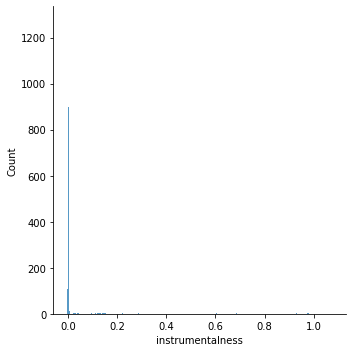

In [4]:
sns.displot(train['instrumentalness'])

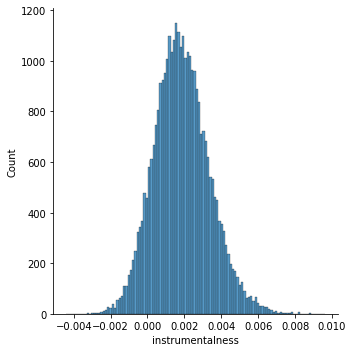

In [6]:
sns.displot(train['instrumentalness'][train['instrumentalness'] < 0.01] )

Once restricted, this look like a Gaussian distribution

In [37]:
df_train_iterimp['instrumentalness_v1'] = df_train_iterimp['instrumentalness'].apply(lambda x: x if x > 0.01 else -1)
df_train_iterimp['instrumentalness_v2'] = df_train_iterimp['instrumentalness'].apply(lambda x: x if x > 0.11 else 0)

X_train, X_valid, y_train, y_valid = train_test_split(df_train_iterimp, train['song_popularity'], test_size=0.2, random_state=42)

In [30]:
opt = BayesSearchCV(RandomForestClassifier(), param, n_iter=32, cv=5, scoring='roc_auc', random_state=42, n_jobs = 5)

opt.fit(X_train, y_train)

BayesSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=32, n_jobs=5,
              random_state=42, scoring='roc_auc',
              search_spaces={'class_weight': ['balanced', None,
                                              'balanced_subsample'],
                             'max_depth': (1, 50),
                             'max_features': ['auto', 'sqrt', 'log2'],
                             'min_samples_leaf': (1, 30),
                             'min_samples_split': (2, 20),
                             'n_estimators': (100, 500)})

In [31]:
opt.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       max_features='log2', min_samples_leaf=30,
                       min_samples_split=20, n_estimators=500)

In [34]:
train['instrumentalness_v1'] = train['instrumentalness'].apply(lambda x: x if x > 0.01 else -1)
train['instrumentalness_v2'] = train['instrumentalness'].apply(lambda x: x if x > 0.11 else 0)

useful_cols = [col for col in train.columns if col not in ['id', 'song_popularity']]
train_iterimp = it_imputer.fit_transform(train[useful_cols])
# test_iterimp = it_imputer.transform(test[useful_cols])
df_train_iterimp = pd.DataFrame(train_iterimp, columns=useful_cols)

X_train, X_valid, y_train, y_valid = train_test_split(df_train_iterimp, train['song_popularity'], test_size=0.2, random_state=42)

In [38]:
useful_cols = [col for col in train.columns if col not in ['id', 'song_popularity', 'instrumentalness']]
clf_bayes = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=12, min_samples_split=20, min_samples_leaf=30, class_weight='balanced_subsample')
clf_bayes.fit(X_train, y_train)
print(clf_bayes.score(X_valid, y_valid))
LR_AUC = roc_auc_score(y_valid, clf_bayes.predict_proba(X_valid)[:,1])
print("AUC: " + str(LR_AUC))

0.563125
AUC: 0.5709947273806222


In [39]:
submission = pd.read_csv('../raw_data/sample_submission.csv', index_col = 0)
useful_cols = [col for col in test.columns if col not in ['id', 'song_popularity','instrumentalness_v1', 'instrumentalness_v2']]
df_test = pd.DataFrame(test_iterimp, columns=useful_cols)

useful_cols = [col for col in df_train_iterimp.columns if col not in ['id', 'song_popularity']]

df_test['instrumentalness_v1'] = df_test['instrumentalness'].apply(lambda x: x if x > 0.01 else -1)
df_test['instrumentalness_v2'] = df_test['instrumentalness'].apply(lambda x: x if x > 0.11 else 0)
submission['song_popularity'] = clf_bayes.predict_proba(df_test[useful_cols])[:,1]
submission.head()
submission.to_csv('../submissions/submission_rf_balanced_subsample_new_instry.csv')

In [40]:
opt_iterimp = BayesSearchCV(RandomForestClassifier(), param, n_iter=32, cv=5, scoring='roc_auc', random_state=42, n_jobs = 5)

opt_iterimp.fit(X_train, y_train)
opt_iterimp.best_estimator_

RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=30,
                       min_samples_split=19, n_estimators=387)

In [42]:
clf_bayes = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=15, min_samples_split=19, min_samples_leaf=30, class_weight='balanced_subsample')
# clf_bayes = opt_iterimp.best_estimator_
clf_bayes.fit(X_train, y_train)
print(clf_bayes.score(X_valid, y_valid))
LR_AUC = roc_auc_score(y_valid, clf_bayes.predict_proba(X_valid)[:,1])
print("AUC: " + str(LR_AUC))

0.569875
AUC: 0.5723502622066482


In [43]:
submission = pd.read_csv('../raw_data/sample_submission.csv', index_col = 0)

submission['song_popularity'] = clf_bayes.predict_proba(df_test[useful_cols])[:,1]
submission.head()
submission.to_csv('../submissions/submission_rf_balanced_subsample_new_instru_bayes.csv')

NameError: name 'X_train' is not defined